
Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.38, value end = $ 1007859.12

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1029951.73, value end = $ 1011169.40
  Strategy "Mininum Variance Portfolio", value begin = $ 1029472.10, value end = $ 1032916.68
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1027428.33, value end = $ 1001308.58

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1085647.24, value end = $ 1027659.

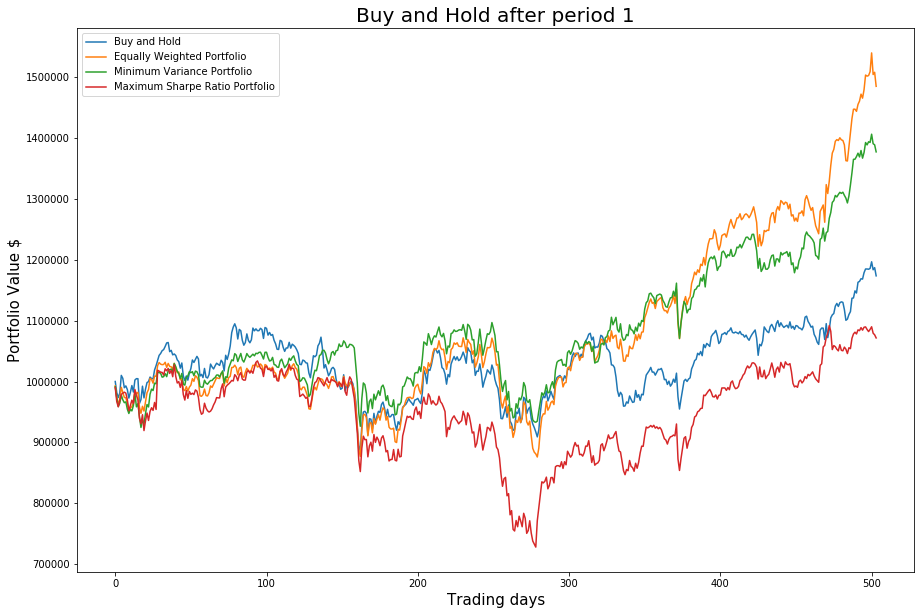

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cvxpy as cp
import cplex
import matplotlib.pyplot as plt

# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    portfolio_value = np.sum(x_optimal*cur_prices) + cash_optimal
    w_optimal = (x_optimal*cur_prices)/portfolio_value
   
    return x_optimal, cash_optimal, w_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init                 #Calculation of total value begin
    allocated_money = np.array(len(x_init)*[portfolio_value/len(x_init)])   #Equally weighted distribution of total money
    x_optimal = np.floor(allocated_money/cur_prices)                        #Rounding down procedure for calculation of shares
                    
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost for both buying and selling
    cash_optimal = portfolio_value - np.sum(cur_prices*x_optimal) - transaction_cost #cash = asset - stock value- transaction cost
    w_optimal = (x_optimal*cur_prices)/portfolio_value

    return x_optimal, cash_optimal, w_optimal 

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    A = []
    for k in range(n):
        A.append([[0],[1]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")                  
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w_minVar = cpx.solution.get_values()
    w_minVar = np.asarray(w_minVar)
    
    allocated_money = w_minVar*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 #Convert the weight optimal to position optimal        
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal, w_minVar

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    
    n = len(x_init)+1
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n                                   #Value of kappa may greater than 1, thus np.inf is used as bound
    
    daily_r_rf = 1.025**(1.0/252)-1
    diff = mu - daily_r_rf
    
    coe_k = np.zeros((20,1))
    Q = np.hstack((Q,coe_k))
    coe_k = np.zeros((1,21))
    Q = np.vstack((Q,coe_k))
    
    A = []
    for k in range(20):
        A.append([[0,1],[diff[k],1]])
    A.append([[0,1],[0,-1]])
    
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_maxSharpe = cpx.solution.get_values()
    w_optimal = np.asarray(w_maxSharpe)                         #the weight distribution of maxSharpe
    w_maxSharpe = w_optimal[0:20]/w_optimal[20]
    
    allocated_money = w_maxSharpe*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 # Convert weight optimal to postion optimal(x_optimal
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal, w_maxSharpe

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
N_strat = 4  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:                                                             #Only re-balance the portofolio at period 1
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
         x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
         
         if cash[strategy][period-1]<0:
            portfolio_value = np.sum(curr_positions*cur_prices) + curr_cash       #Portfolio value before the balance strategy
            ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])           #Determine the current weight distribution
            cash_excess = abs(cash[strategy][period-1])* ratio                    #Distribute over-draft cash by weight to each stock
            position_excess = np.ceil(cash_excess/cur_prices)                     #Determine how many excess shares bought for each stock
            x[strategy][period-1] = x[strategy][period-1] - position_excess       #Recalculation of optimal position of stocks by substracting excess shares bought
            transaction_cost = np.dot(cur_prices, abs(x[strategy][period-1]-curr_positions))*0.005
            cash[strategy][period-1] = portfolio_value - np.sum(cur_prices*x[strategy][period-1]) - transaction_cost
            


      
      else:
         x[strategy, period-1] = x[strategy, period-2]                            #Hold the portofolio till the end of period 12
         cash[strategy, period-1] = cash[strategy, period-1]

      
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted Portfolio')
plt.plot(portf_value[2], label = 'Minimum Variance Portfolio')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.legend()
plt.ylabel('Portfolio Value $', fontsize=15)
plt.xlabel('Trading days', fontsize=15)
plt.title('Buy and Hold after period 1', fontsize=20)
plt.show()

In [11]:
x[1]

array([array([ 1065.,  3225.,  1497.,    94.,  2715.,   993.,   757.,  1060.,
         456.,   307.,  1469.,  1800.,  2771.,  1369., 17748.,  2414.,
        2465.,   161.,  1286.,  1230.]),
       array([ 1065.,  3225.,  1497.,    94.,  2715.,   993.,   757.,  1060.,
         456.,   307.,  1469.,  1800.,  2771.,  1369., 17748.,  2414.,
        2465.,   161.,  1286.,  1230.]),
       array([ 1065.,  3225.,  1497.,    94.,  2715.,   993.,   757.,  1060.,
         456.,   307.,  1469.,  1800.,  2771.,  1369., 17748.,  2414.,
        2465.,   161.,  1286.,  1230.]),
       array([ 1065.,  3225.,  1497.,    94.,  2715.,   993.,   757.,  1060.,
         456.,   307.,  1469.,  1800.,  2771.,  1369., 17748.,  2414.,
        2465.,   161.,  1286.,  1230.]),
       array([ 1065.,  3225.,  1497.,    94.,  2715.,   993.,   757.,  1060.,
         456.,   307.,  1469.,  1800.,  2771.,  1369., 17748.,  2414.,
        2465.,   161.,  1286.,  1230.]),
       array([ 1065.,  3225.,  1497.,    94.,  271

In [12]:
x[2]

array([array([  991.,     0.,     0.,   208.,     0.,     0.,    95.,  4105.,
           0.,     0.,     0.,  5407.,     0.,     0., 20998.,     0.,
           0.,    63.,     0., 10171.]),
       array([  991.,     0.,     0.,   208.,     0.,     0.,    95.,  4105.,
           0.,     0.,     0.,  5407.,     0.,     0., 20998.,     0.,
           0.,    63.,     0., 10171.]),
       array([  991.,     0.,     0.,   208.,     0.,     0.,    95.,  4105.,
           0.,     0.,     0.,  5407.,     0.,     0., 20998.,     0.,
           0.,    63.,     0., 10171.]),
       array([  991.,     0.,     0.,   208.,     0.,     0.,    95.,  4105.,
           0.,     0.,     0.,  5407.,     0.,     0., 20998.,     0.,
           0.,    63.,     0., 10171.]),
       array([  991.,     0.,     0.,   208.,     0.,     0.,    95.,  4105.,
           0.,     0.,     0.,  5407.,     0.,     0., 20998.,     0.,
           0.,    63.,     0., 10171.]),
       array([  991.,     0.,     0.,   208.,     

In [13]:
x[3]

array([array([    0.,     0.,     0.,     0.,  2135.,     0.,     0.,     0.,
           0.,     0.,     0., 23832.,     0.,     0.,     0.,     0.,
           0.,     0.,  7605.,     0.]),
       array([    0.,     0.,     0.,     0.,  2135.,     0.,     0.,     0.,
           0.,     0.,     0., 23832.,     0.,     0.,     0.,     0.,
           0.,     0.,  7605.,     0.]),
       array([    0.,     0.,     0.,     0.,  2135.,     0.,     0.,     0.,
           0.,     0.,     0., 23832.,     0.,     0.,     0.,     0.,
           0.,     0.,  7605.,     0.]),
       array([    0.,     0.,     0.,     0.,  2135.,     0.,     0.,     0.,
           0.,     0.,     0., 23832.,     0.,     0.,     0.,     0.,
           0.,     0.,  7605.,     0.]),
       array([    0.,     0.,     0.,     0.,  2135.,     0.,     0.,     0.,
           0.,     0.,     0., 23832.,     0.,     0.,     0.,     0.,
           0.,     0.,  7605.,     0.]),
       array([    0.,     0.,     0.,     0.,  213